Dataset contains simultaneous recordings of 10,000 or 20,000 neurons from mouse visual cortex either during the presentation of gratings or during spontaneous behaviors like running, whisking and sniffing. These datasets are a little more advanced because you have to work with many neurons simultaneously. They are exciting, because they give a taste of what’s to come in neuroscience.

In [2]:
import numpy as np
import matplotlib.pyplot as plt


Load the data

In [35]:
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys(), dat2.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz']) dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


Get the correct data. Our goal is to train a decoder to predict the mouse’s pupils area. This is a 1D variable to predict. We can build a linear decoder for neural activity.
we have over 11_000 predictors/regressors to predict the output pupil size.

$$pupil_area = \underbrace{a_0\theta_0 + ... + a_n\theta_n}_{n}, \text{ with }n=11,983$$




In [4]:
#Looking at our dat
neural_resp = dat['sresp']
pupil_resp = dat['pupilArea']
print("neural response data_size:",neural_resp.shape) #(time, neuron)
print("pupil response data_size:", pupil_resp.shape) #(pupil output)

neural response data_size: (11983, 7018)
pupil response data_size: (7018, 1)


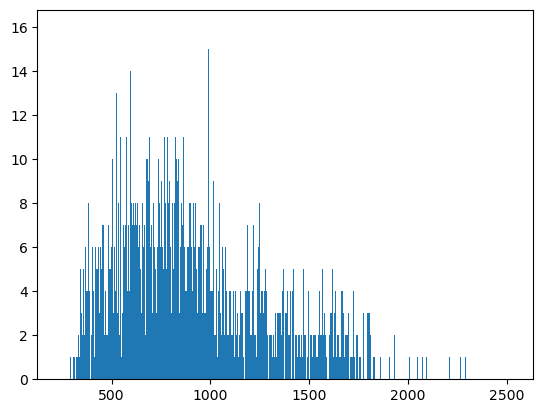

In [24]:
#Let's get an idea of the spread of pupil size
bin_size = pupil_resp.max() - pupil_resp.min() / (4*pupil_resp.size)
hist = plt.hist(pupil_resp, bins=int(bin_size))
# we notice that there are some outliers after about 2000; we won't remove them yet.

In [39]:
#PCA and get top 90 components. this cell will take a long time.
from sklearn.decomposition import PCA
top = 100
np.random.seed(1337)
random_indexes = np.random.choice(range(neural_resp.shape[0]),size=top, replace=False)
X = neural_resp[random_indexes,:]

In [41]:
pca = PCA(n_components=.9)
Y = pca.fit(X)

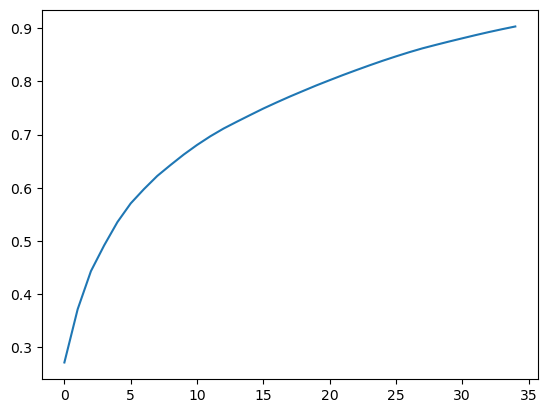

In [47]:
plt.plot(np.cumsum(Y.explained_variance_ratio_))

In [49]:
Y.components_.shape

(35, 7018)

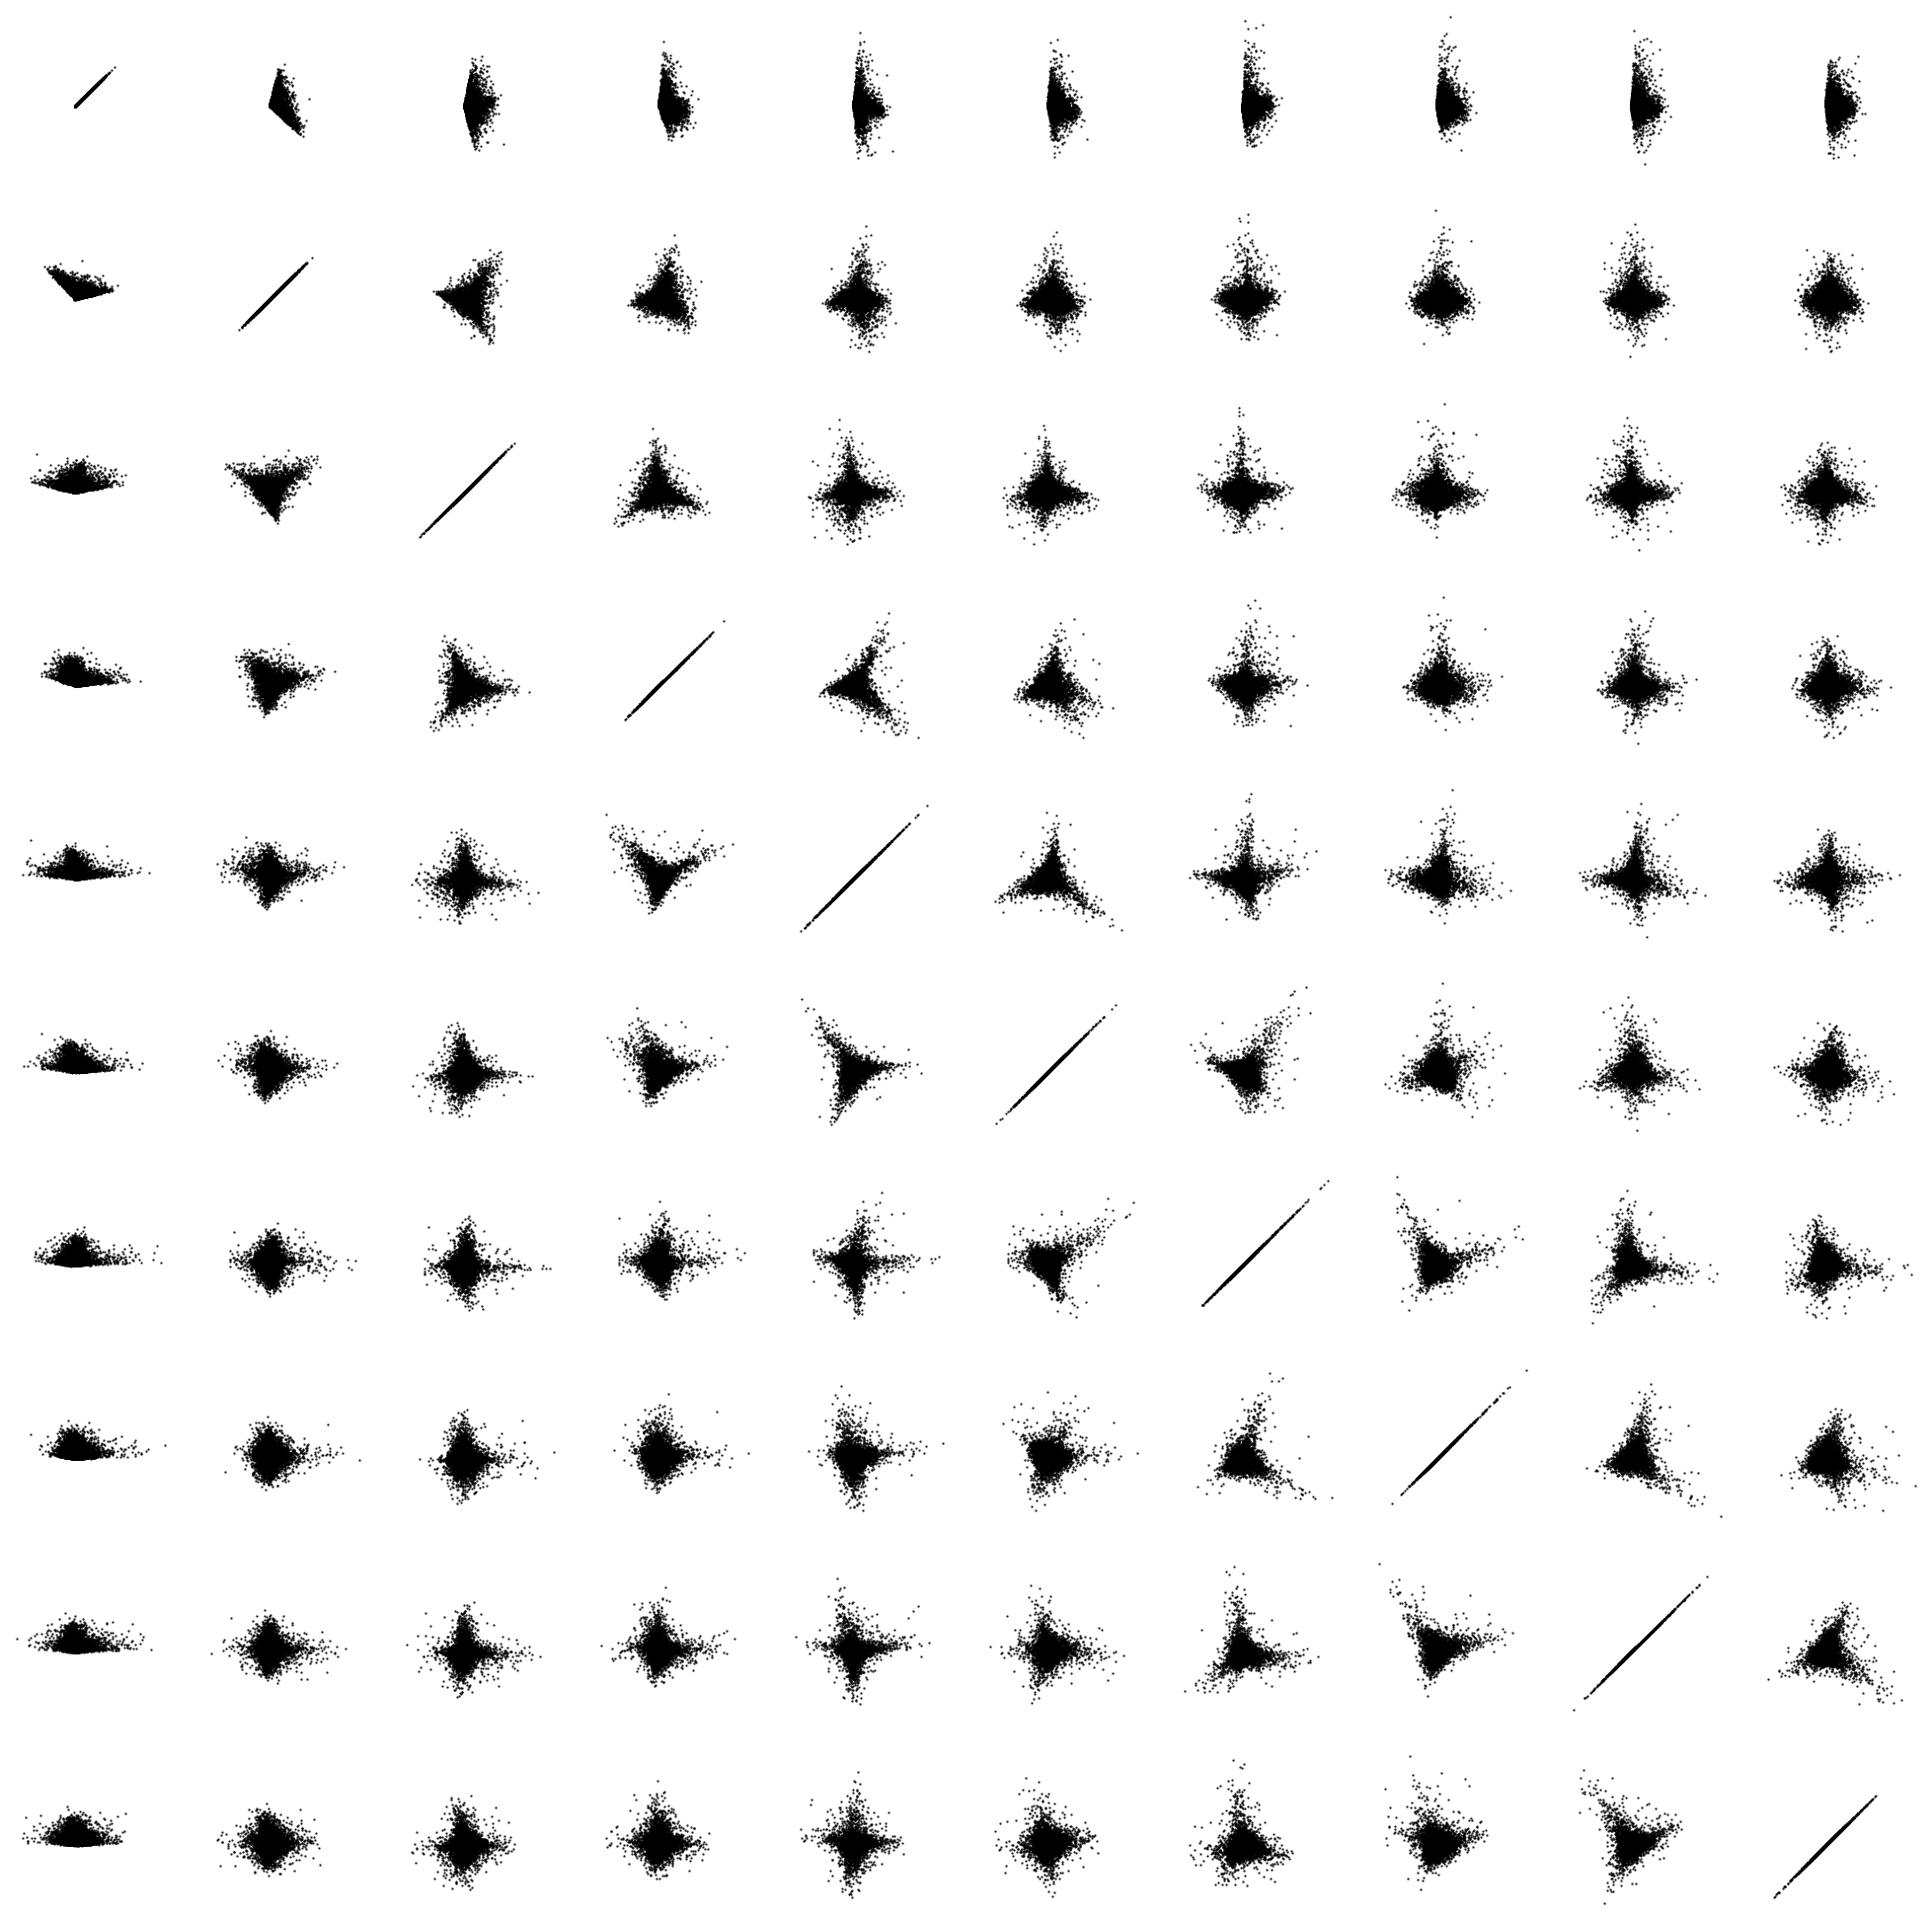

In [63]:
rows = cols = 10
fig, ax = plt.subplots(nrows=rows, ncols=cols, sharey=True, sharex= True, figsize=(rows*2.5,cols*2.5))
for row in range(rows):
    for col in range(cols):
        ax[row,col].scatter(Y.components_[row,:], Y.components_[col,:], c='k', alpha=.8, s=.5)
        ax[row,col].set_axis_off()


In [29]:
from sklearn.cluster import DBSCAN

A = np.column_stack((pupil_resp, neural_resp.T[:,-5:].mean(1)))
# A = radius_neighbors_graph(pupil_resp, radius=1.5 ,mode='distance')
# A = sort_graph_by_row_values(A)
B = DBSCAN(metric='euclidean').fit(A)
labels = B.labels_

In [30]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 7018


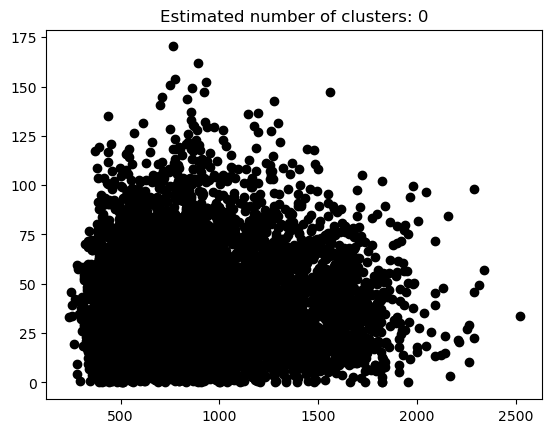

In [31]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[B.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = A[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = A[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()